In [1]:
#  To check the validity of our calclautions of the rate of accretion for isolated 
#  PBHs we shall compare our results with Fig.1 of De Luca et al. 
#  https://arxiv.org/pdf/2003.12589.pdf. 

from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from accretion import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})





# Here, s = a/a_eq
# Here, v = c_s with c_s speed of sound in the surrounding medium.
# Here, γ is the ratio between the PBH mass and the horizon mass.
# z_i = redshift at which PBH formation takes place.

# Reproduction of Fig.1 of De Luca et al. https://arxiv.org/pdf/2003.12589.pdf
# Other useful References: 1.) https://arxiv.org/pdf/0709.0524.pdf
#                          2.) https://arxiv.org/pdf/2003.02778.pdf



## Accretion of matter as per eq. (10) and (11) of https://arxiv.org/pdf/2003.12589.pdf
def m_acc_Luca(t, m):  
    z = t
    y = np.array(m, dtype = np.longdouble)
    
    if z < 0 or z == 0:
        print("i =",   i, ",", "z =", z)
        
    
    def v_eff(z):    #with v_rel given by Eq.(7) of https://arxiv.org/pdf/1707.04206.pdf
        
        def c_s(z):
            β = 1.72
            z_dec = 130
            return  5.74e3 * np.sqrt((1+z)/1000) * (((((1+z_dec)/(1 + z))**β) + 1)**(-1/(2 * β))) * (yr/pc)

        def v_rel(z):
            
            H = H_0 * np.sqrt(Ω_m0 * (1+z)**3)
            H_eq = H_0 * np.sqrt(Ω_m0 * (1+z_eq)**3)
            C = (Ω_m0**(1.2)) * (H**2)/ (2 * np.pi**2)
            r_0 = (1 + z)/H
            a = 1e-5 * r_0

            def Integral_CDM(k):
                def P(k):
                    Ω = 1
                    n = 1
                    alpha = 1.7 * ((Ω * h**2)**(-1)) 
                    beta = 9.0 * ((Ω * h**2)**(-1.5))
                    gamma = 1.0 * ((Ω * h**2)**(-2)) 
                    return (k**n)/((1 + alpha * k + beta * k**(1.5) + gamma * k**2)**2)

                def w_s(k, a):
                    return  (3/(4 * np.pi * (a**3))) * np.heaviside(3, abs(k))

                def w_l(k, r_0):
                    return  (1/((2*np.pi*(r_0**2))**(3/2))) * np.exp(-k**2/(2 *a**2))

                return  P(k) * (w_s(k, a)**2) * (w_l(k, r_0)**2)


            def Integral_baryons(k):
                def P(k):
                    n =1
                    if k > (a_eq * H_eq):
                        return (k**n)
                    else:
                        return (4/225) *  ((1/1+z)**2) * ((k**4)/(Ω_m0**2 * H_0**4)) * (k**n) 

                def w_s(k, a):
                    return  (3/(4 * np.pi * (a**3))) * np.heaviside(3, abs(k))

                def w_l(k, r_0):
                    return  (1/((2*np.pi*(r_0**2))**(3/2))) * np.exp(-k**2/(2 *a**2))

                return   P(k) * (w_s(k, a)**2) * (w_l(k, r_0)**2)


            k = np.linspace(0, 1e20, 10)
            k_list = k.tolist()
            Integral_baryons_list = np.zeros(len(k_list))
            Integral_CDM_list = np.zeros(len(k_list))

            for i, k in enumerate(k_list):
                Integral_CDM_list[i] = Integral_CDM(k)
                Integral_baryons_list[i] = Integral_baryons(k)



            v_CDM = np.sqrt(C * np.trapz(Integral_CDM_list , k_list))
            v_baryons =  np.sqrt(C * np.trapz(Integral_baryons_list , k_list))

            return v_CDM - v_baryons


        def Mach_number(z):
            return v_rel(z)/c_s(z)

        if Mach_number(z) > 1:
            return c_s(z) * (((16/np.sqrt(2 * np.pi)) * (Mach_number(z)**3))**(1/6))  
        else:
            return c_s(z) * np.sqrt( 1 + Mach_number(z)**2)


    
    
    def k(z, m):
        def M_h(z):
            return 3 * y * ((1+z/1000)**(-1))
        return 0.22 * (1+z/1000) * (M_h(z)**(2/3)) * ((1e3 * (yr/pc)/ v_eff(z))**2)

    
    if k(z, m)>=2:
         def λ(z, m):
            def β_cap(z, m):
                x_e = 1e-3
                return 1e-4 * y * (((1+z)/1000)**(3/2)) *  ((5.74e3 * (yr/pc)/v_eff(z))**3) * [0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2))]
            def x_cr(z, m):
                return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
            return np.exp((9/2)/ (3 + β_cap(z, m)*(3/4))) * (x_cr(z, m)**2)
    
    else:
        def λ(z, m):
            p = 2 - alpha
            power = p/(1-p)
            def β_cap(z, m):
                x_e = 1e-3
                return (k(z, m)**power) * 1e-4 * y * (((1+z)/1000)**(3/2)) *  ((5.74e3 * (yr/pc)/v_eff(z))**3) * [0.257 + 1.45 * (x_e/0.01) * (((1+z)/1000)**(5/2))]
            def x_cr(z, m):
                return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
            def gamma_bar(z, m):
                return ((1 + 10 * β_cap(z, m))**(1/10)) * np.exp(2 - k(z, m)) * ((k(z, m)/2)**2)
            return (gamma_bar(z, m)**power) * np.exp((9/2)/ (3 + β_cap(z, m)*(3/4))) * (x_cr(z, m)**2)



    
    def m_dot(z, m):  #Eq.(11) in https://arxiv.org/abs/2003.12589
        return   2.4e-2 * λ(z, m) * ((1+z)/1000) *  y * ((5.74e3 * (yr/pc)/v_eff(z))**3) 

    def dt_dz(z):
        x = ((Ω_r0 * ((1 + z)**6)) + (Ω_m0 * ((1 + z)**5)))
        return  - np.sqrt(3/(8 * π * G * ρ_c0)) * (x**(-1/2))
    
    return 2e-3 *  m_dot(z, m) * (y/1e6) *  dt_dz(z)

/tmp/ipykernel_5065/3807531419.py:136: RuntimeWarning: invalid value encountered in true_divide
  return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
/tmp/ipykernel_5065/3807531419.py:136: RuntimeWarning: invalid value encountered in sqrt
  return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
/tmp/ipykernel_5065/3807531419.py:136: RuntimeWarning: invalid value encountered in true_divide
  return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
/tmp/ipykernel_5065/3807531419.py:136: RuntimeWarning: invalid value encountered in sqrt
  return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
/tmp/ipykernel_5065/3807531419.py:136: RuntimeWarning: invalid value encountered in true_divide
  return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
/tmp/ipykernel_5065/3807531419.py:136: RuntimeWarning: invalid value encountered in sqrt
  return (-1 + np.sqrt(1 + β_cap(z, m)))/β_cap(z, m)
/home/pratibhajangra/miniconda3/envs/PhD/lib/python3.9/site-packages/numpy/ma/core.py:6852: RuntimeWarning: overflow encountere

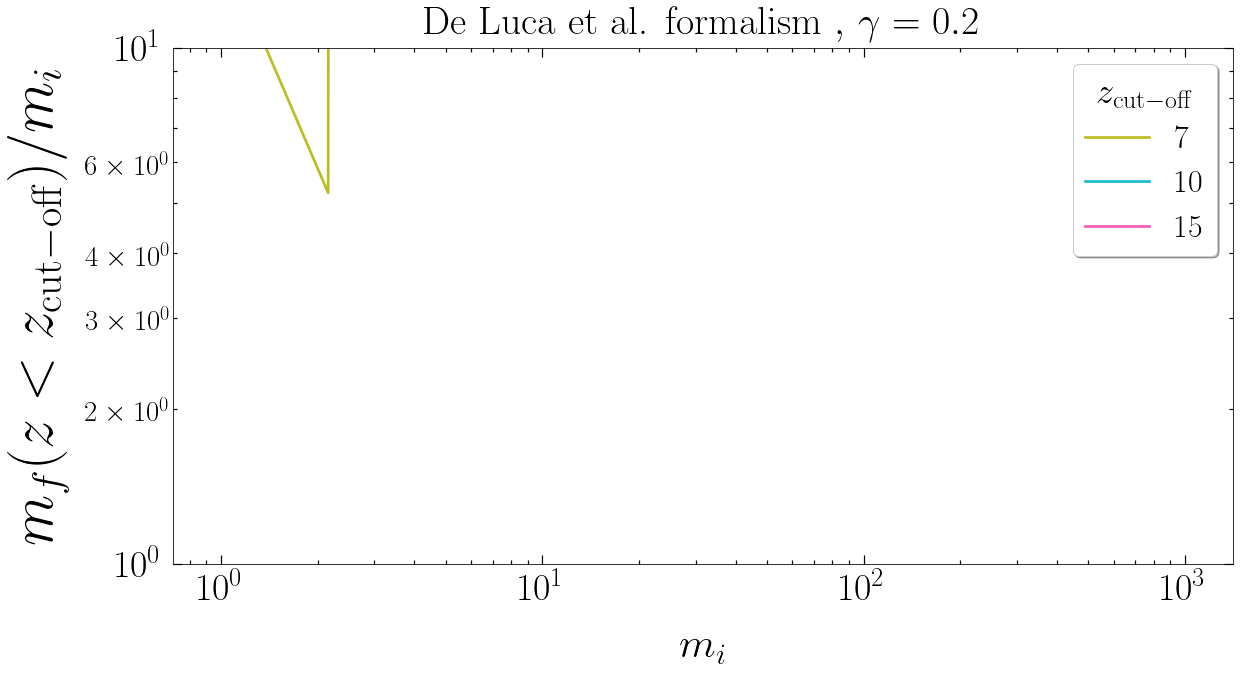

In [2]:
# Baryon accretion as per as per eq. (10) and (11) of Luca et. al https://arxiv.org/pdf/2003.12589.pdf 
# to upto z_cut-off = 5.
# Here, m_f(z < z_cut-off)/m_i implies  m_f(z = z_cut-off)/m_i.

m_spacing = 10
mi_arr = np.geomspace(1, 1e3, m_spacing)





fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_cut_arr = np.array([7, 10, 15])
mf_arr = np.zeros(len(mi_arr))
colors = ['C8', 'C9',  '#f15bb5']
plot_lines = []
N = 10
alpha = 3
for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    for j, m in enumerate(mi_arr):
        γ = 0.2
        z_1i = z_pbh(m,  γ)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1 = solve_ivp(m_acc_Luca, t_span = [t1[0], t1[-1]], y0 = [y_1i], method = 'DOP853',  t_eval = t1)
        t1 = sol1.t
        y1 = sol1.y[0]


        z_2i = z_eq
        y_2i = y1[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        sol2 = solve_ivp(m_acc_Luca, t_span = [t2[0], t2[-1]], y0 = [y_2i], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2.t
        y2 = sol2.y[0]



        z_3i = z_rec
        y_3i = y2[-1]
        z_cut_off3 = z_th
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        sol3 = solve_ivp(m_acc_Luca, t_span = [t3[0], t3[-1]], y0 = [y_3i], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        t3 = sol3.t
        y3 = sol3.y[0]

        
        z_4i = z_th
        y_4i = y3[-1]
        z_cut_off4 = 90
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        sol4 = solve_ivp(m_acc_Luca, t_span = [t4[0], t4[-1]], y0 = [y_4i], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 5)
        t4 = sol4.t
        y4 = sol4.y[0]


        
        z_5i = z_cut_off4
        y_5i = y4[-1]
        z_cut_off5 = z_cut
        t5 = np.geomspace(z_5i, z_cut_off5, N)
        t_span = [t5[0], t5[-1]]
        sol5 = solve_ivp(m_acc_Luca, t_span = [t5[0], t5[-1]], y0 = [y_5i], method = 'DOP853',  t_eval = t5, first_step = 1, max_step = 3)
        t5 = sol5.t
        y5 = sol5.y[0]
        
        
        mf_arr[j] = y5[-1]
        

        
    ax.loglog(mi_arr, np.divide(mf_arr, mi_arr), color = color)
        
        
       
    
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 29)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$m_{i}$',fontsize = 43, labelpad = 20)
plt.ylabel(r'$m_{f}(z < z_\mathrm{cut-off})/m_{i} $',fontsize = 60, labelpad = 16)
plt.legend(['$7$', '$10$', '$15$'], 
           prop = {'size':32}, loc = 'upper right', shadow = True, 
           title = '$z_\mathrm{cut-off}$' ,
           title_fontsize = 37, facecolor = 'white', fontsize = 65)
plt.xscale('log')
plt.title(r' De Luca et al. formalism $,\, \gamma = 0.2$', fontsize = 40, pad = 13)
#plt.savefig('Luca_z_diff_cutoff.pdf', bbox_inches = 'tight')
plt.show()